In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [ ]:
dataset = pd.read_csv('/content/weather_data.csv')
dataset.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,Rain,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,Rain,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,Rain,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,Rain,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,Rain,38.062329,1030.264331


In [ ]:
print(len(dataset))
print(dataset.isnull().sum())

311
date                0
avg_temperature    15
humidity           15
avg_wind_speed     15
rain_or_not         0
cloud_cover        15
pressure            0
dtype: int64


In [ ]:
dataset.describe()

,avg_temperature,humidity,avg_wind_speed,cloud_cover,pressure
count,296.000000,296.000000,296.000000,296.000000,311.000000
mean,25.983840,55.041385,7.556636,49.834827,1001.059119
std,6.802475,19.220133,5.344683,29.009459,28.835595
min,15.000000,30.000000,0.069480,0.321826,951.240404
25%,20.265692,34.280826,3.550354,24.530951,975.757545
50%,27.177958,56.759806,7.326421,50.725120,1001.938586
75%,32.204599,72.189837,11.050627,76.046506,1026.578884
max,35.000000,90.000000,56.636041,99.834751,1049.543752


In [ ]:
dataset['rain_or_not'].replace({'No Rain': 0, 'Rain': 1},inplace = True)

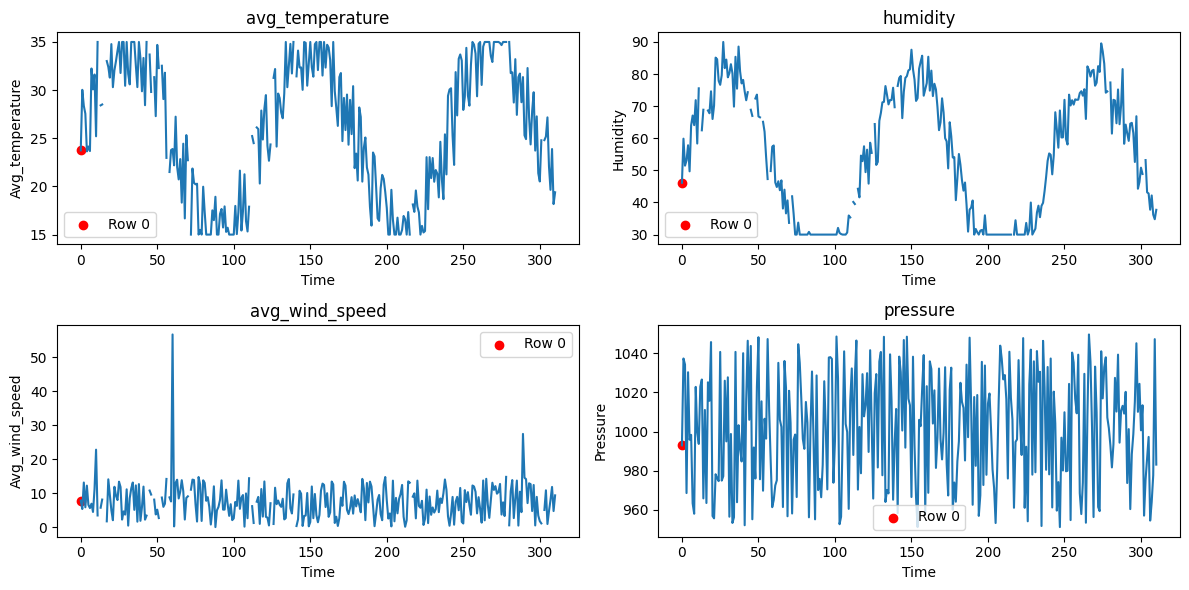

In [ ]:
# prompt: create tieme series plot for features in one row

import matplotlib.pyplot as plt

def plot_features_for_row(row_index):
    row = dataset.iloc[row_index]
    features =['avg_temperature', 'humidity', 'avg_wind_speed', 'pressure']  # Add other features as needed

    plt.figure(figsize=(12, 6))  # Adjust figure size for better visualization

    for i, feature in enumerate(features):
        plt.subplot(2, 2, i + 1) # Adjust subplot layout if needed
        plt.plot(dataset.index, dataset[feature])
        plt.scatter(row_index, row[feature], color='red', label=f'Row {row_index}') # Highlight the selected row
        plt.title(feature)
        plt.xlabel("Time")
        plt.ylabel(feature.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_features_for_row(0) # Replace 0 with the row index you want to plot


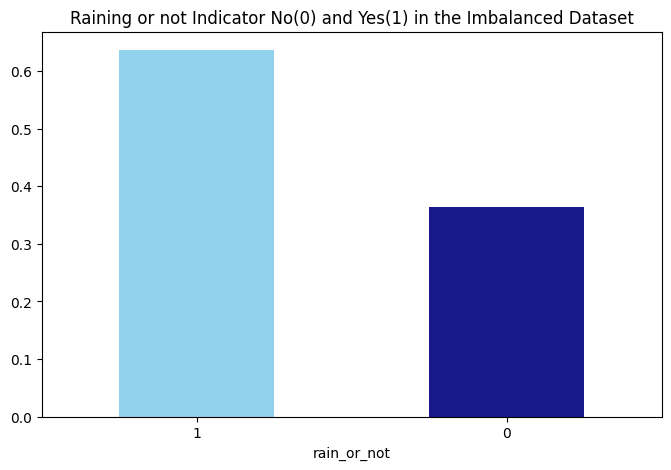

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
dataset['rain_or_not'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('Raining or not Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

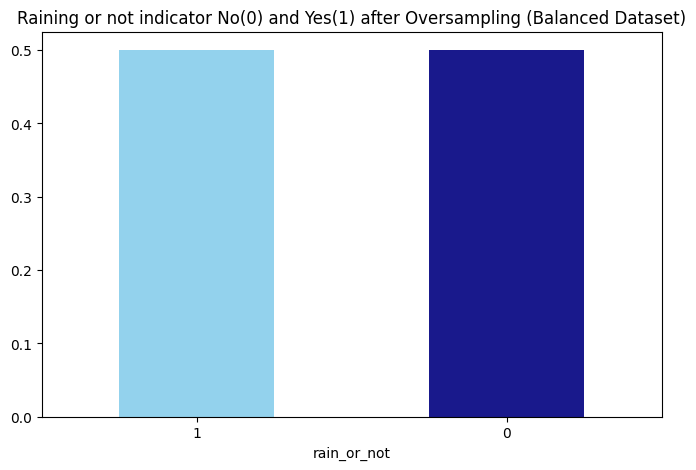

In [ ]:
from sklearn.utils import resample
no_rain = dataset[dataset['rain_or_not'] == 0]
rain = dataset[dataset['rain_or_not'] == 1]
no_rain_oversampled = resample(no_rain, replace=True, n_samples=len(rain), random_state=42)
oversampled = pd.concat([rain, no_rain_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled['rain_or_not'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('Raining or not indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [ ]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
avg_temperature,18,0.045455
humidity,18,0.045455
avg_wind_speed,18,0.045455
cloud_cover,18,0.045455


In [ ]:
oversampled.select_dtypes(include=['object']).columns

Index(['date'], dtype='object')

In [ ]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [ ]:
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [ ]:
MiceImputed.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,0,23.745401,46.140905,7.845981,1,20.851051,992.965681
1,1,30.030503,59.876587,5.382457,1,93.059521,1037.273025
2,2,28.365224,51.464618,13.158008,1,11.636640,1034.193357
3,3,27.550929,53.103799,5.886677,1,81.744971,968.610142
4,4,23.639303,57.826186,12.248992,1,38.062329,1030.264331


In [ ]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

date               149.500000
avg_temperature     11.185877
humidity            35.753658
avg_wind_speed       6.842869
rain_or_not          1.000000
cloud_cover         47.002831
pressure            48.509424
dtype: float64


In [ ]:
# Removing outliers from dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(393, 7)

<Axes: >

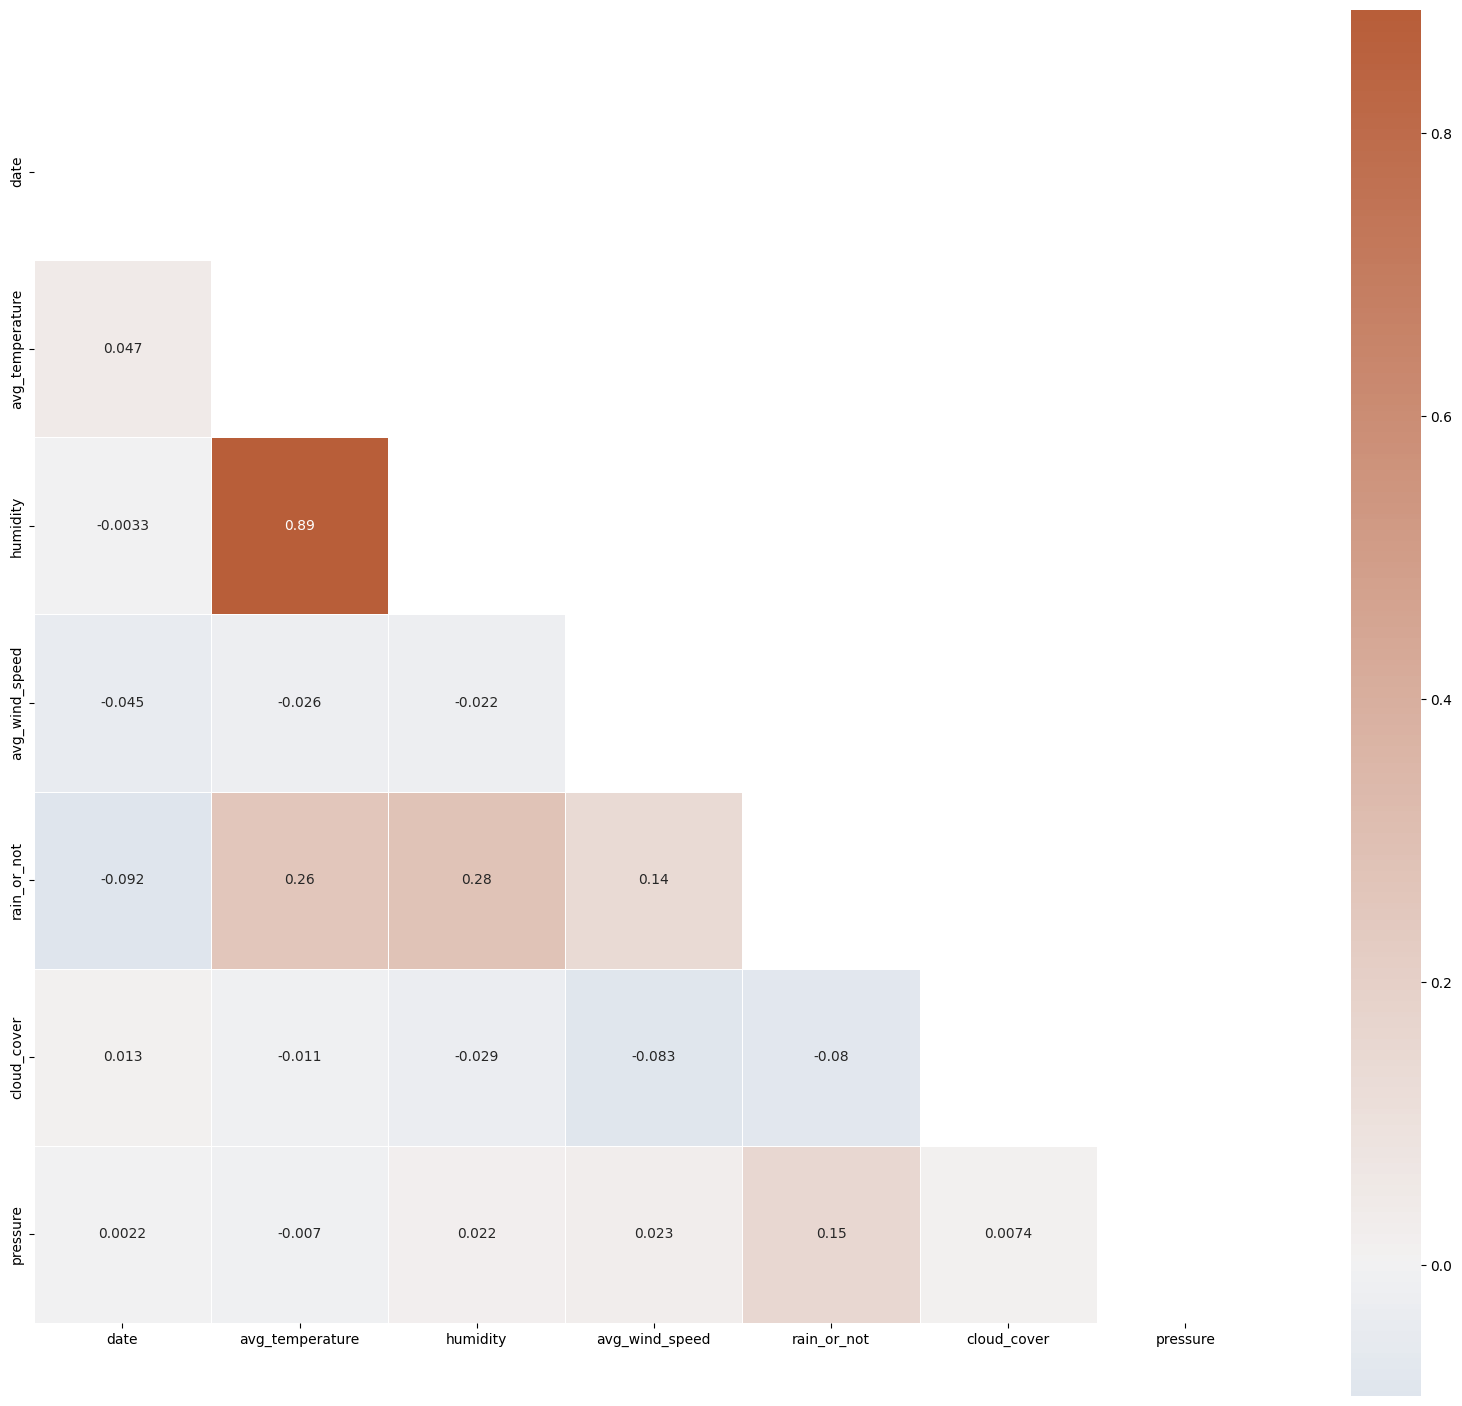

In [ ]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

In [ ]:
MiceImputed.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,0,23.745401,46.140905,7.845981,1,20.851051,992.965681
1,1,30.030503,59.876587,5.382457,1,93.059521,1037.273025
2,2,28.365224,51.464618,13.158008,1,11.636640,1034.193357
3,3,27.550929,53.103799,5.886677,1,81.744971,968.610142
4,4,23.639303,57.826186,12.248992,1,38.062329,1030.264331


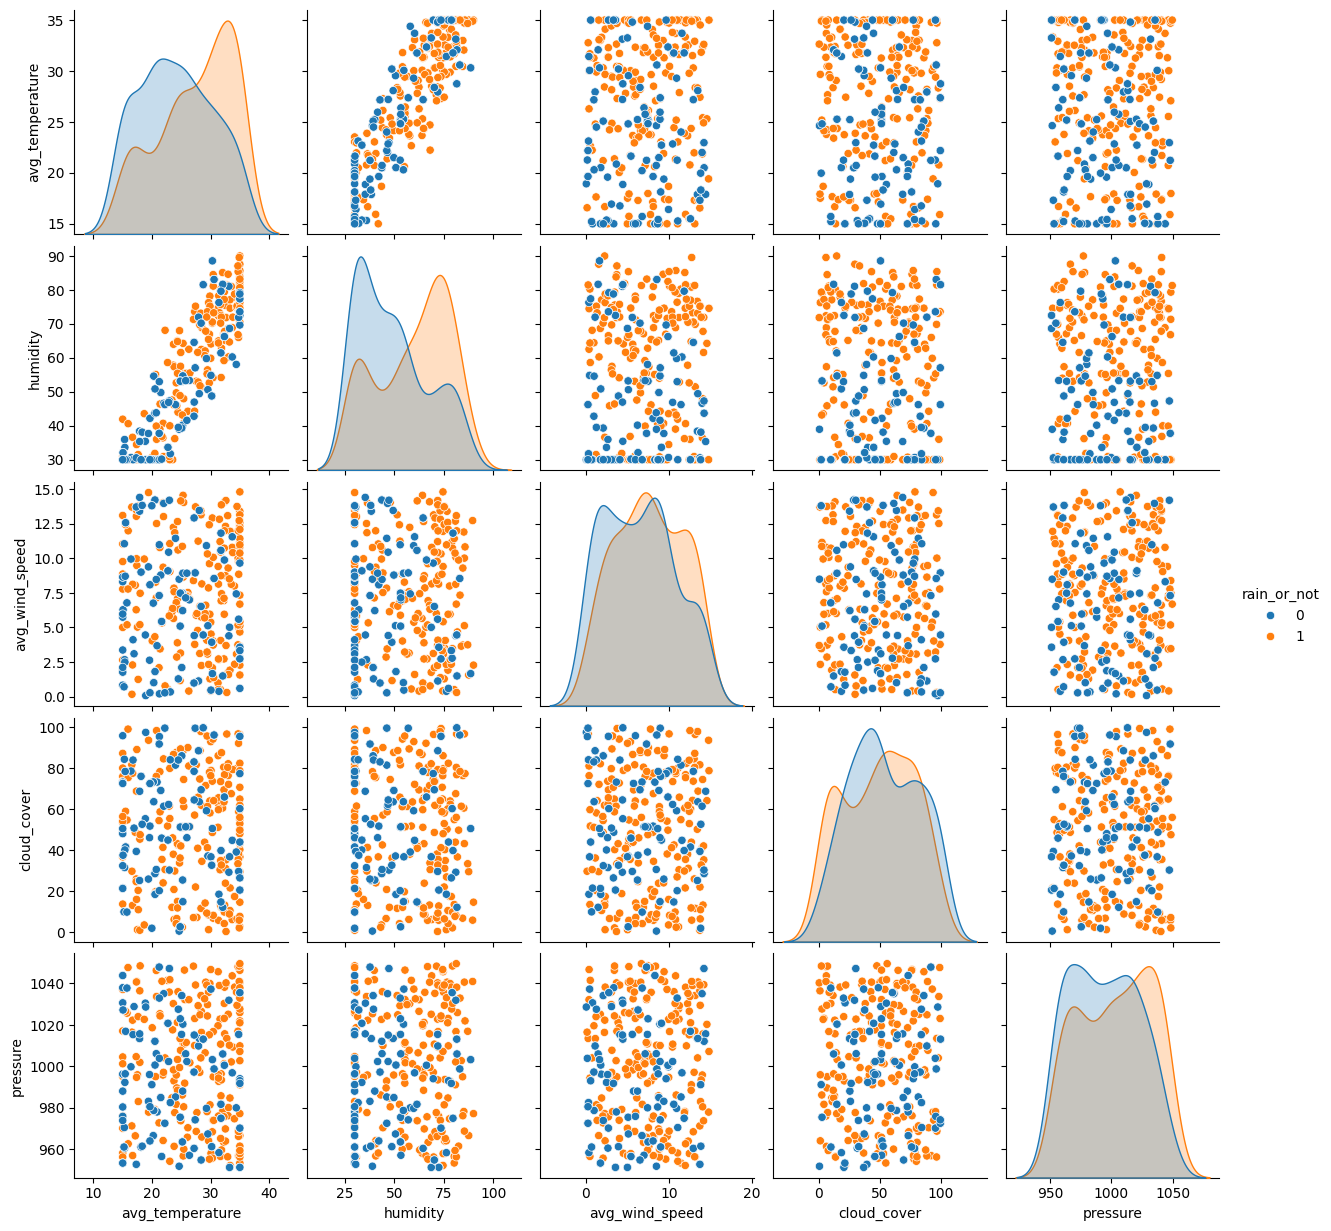

In [ ]:
sns.pairplot( data=MiceImputed, vars=('avg_temperature','humidity','avg_wind_speed','cloud_cover', 'pressure'), hue='rain_or_not' )

In [ ]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)
modified_data.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,0.000000,0.437270,0.269015,0.527380,1.0,0.206297,0.424454
1,0.003460,0.751525,0.497943,0.360311,1.0,0.931916,0.875175
2,0.006920,0.668261,0.357744,0.887626,1.0,0.113702,0.843847
3,0.010381,0.627546,0.385063,0.394505,1.0,0.818217,0.176695
4,0.013841,0.431965,0.463770,0.825979,1.0,0.379252,0.803878


In [ ]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='rain_or_not']
y = modified_data[['rain_or_not']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['date', 'avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover',
       'pressure'],
      dtype='object')


In [ ]:
features = MiceImputed[['date', 'avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover',
       'pressure']]
target = MiceImputed['rain_or_not']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
def plot_roc_cur(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report
# Instead of importing plot_confusion_matrix directly, import confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))

    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    plot_roc_cur(fper, tper)

    # Create the confusion matrix manually
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix using seaborn
    # Remove the 'normalize' argument
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # removed normalize = 'all'
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.6565656565656566
ROC Area under Curve = 0.6556372549019608
Cohen's Kappa = 0.3116564417177914
Time taken = 0.2167205810546875
              precision    recall  f1-score   support

           0    0.65217   0.62500   0.63830        48
           1    0.66038   0.68627   0.67308        51

    accuracy                        0.65657        99
   macro avg    0.65628   0.65564   0.65569        99
weighted avg    0.65640   0.65657   0.65621        99



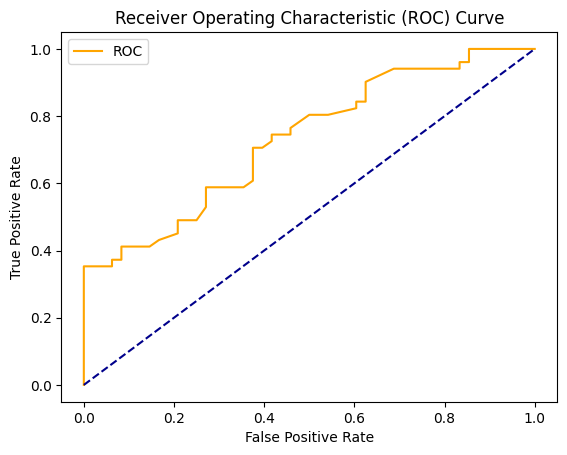

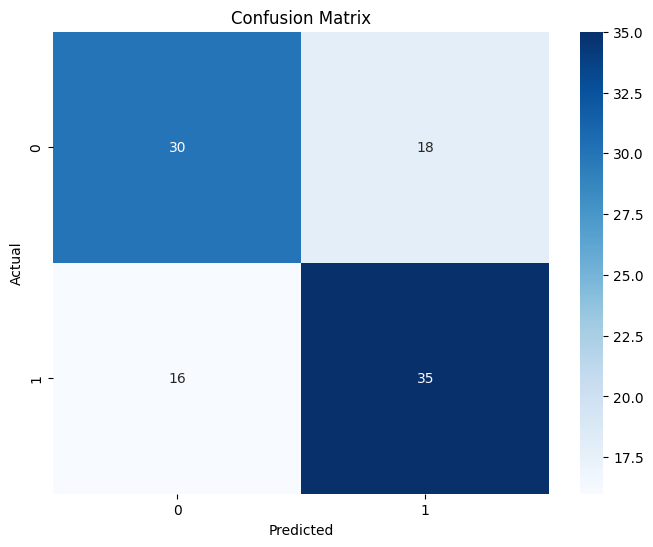

In [ ]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.5 MB/s eta 0:00:00


Accuracy = 0.7474747474747475
ROC Area under Curve = 0.7506127450980392
Cohen's Kappa = 0.4978697504564821
Time taken = 98.49981904029846
              precision    recall  f1-score   support

           0    0.69492   0.85417   0.76636        48
           1    0.82500   0.64706   0.72527        51

    accuracy                        0.74747        99
   macro avg    0.75996   0.75061   0.74581        99
weighted avg    0.76193   0.74747   0.74519        99



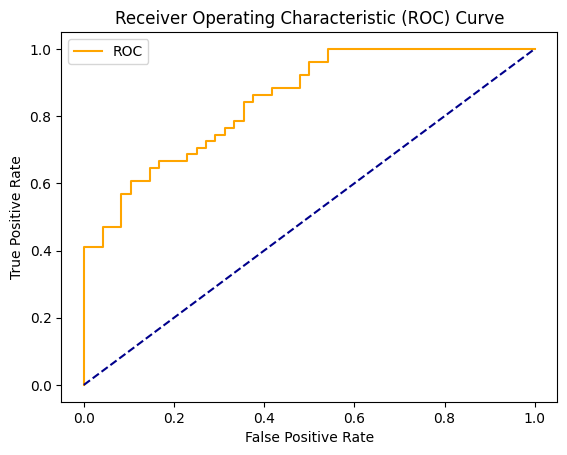

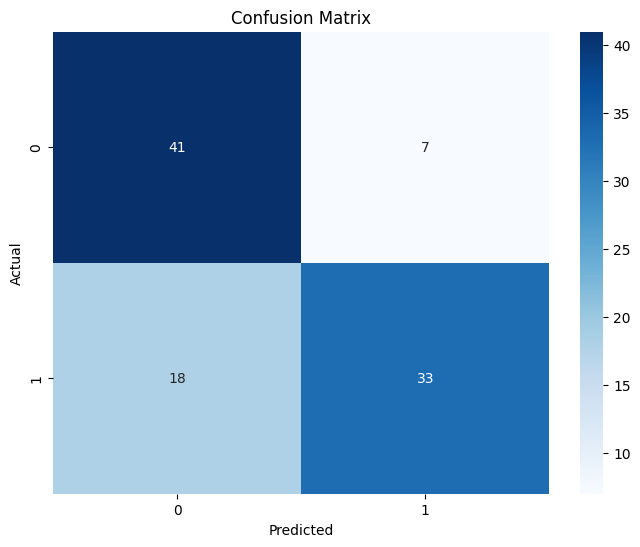

In [ ]:
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

Accuracy = 0.6161616161616161
ROC Area under Curve = 0.6158088235294118
Cohen's Kappa = 0.23161764705882348
Time taken = 0.42696213722229004
              precision    recall  f1-score   support

           0    0.60417   0.60417   0.60417        48
           1    0.62745   0.62745   0.62745        51

    accuracy                        0.61616        99
   macro avg    0.61581   0.61581   0.61581        99
weighted avg    0.61616   0.61616   0.61616        99



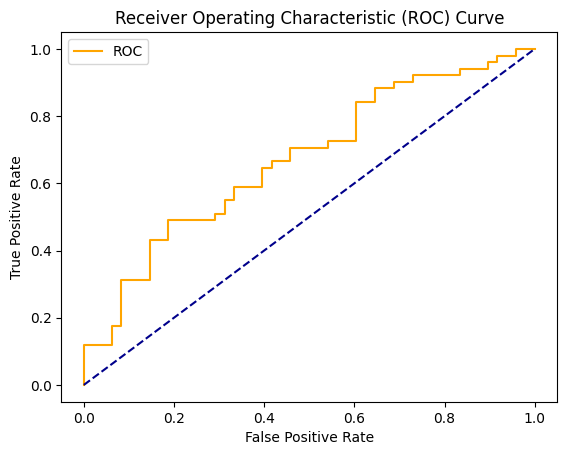

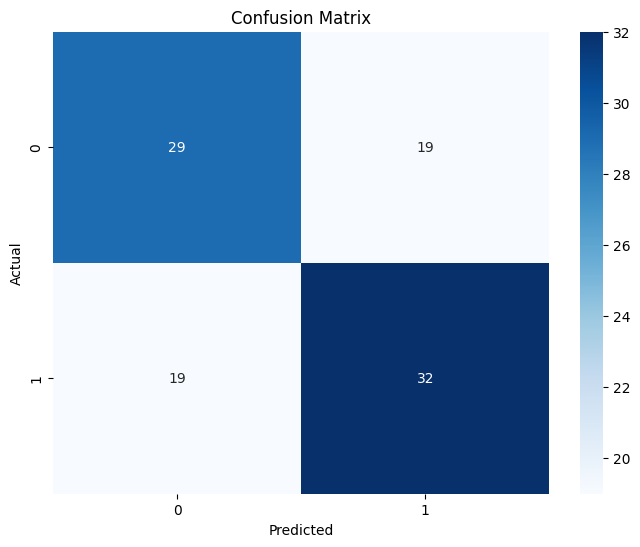

In [ ]:
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)